In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
ls

book.zip  sample_data/


In [5]:
!unzip book.zip

Archive:  book.zip
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


In [6]:
books = pd.read_csv('BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
users = pd.read_csv('BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']
ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:27

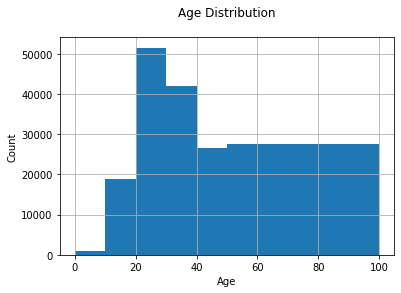

In [9]:
users.Age.hist(bins=[0, 10, 20, 30, 40, 50, 100])
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

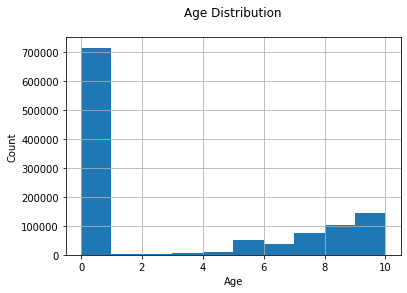

In [14]:
ratings.bookRating.hist(bins=[0,1,2,3,4,5,6,7,8,9,10])
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [20]:
counts1 = ratings['userID'].value_counts()
ratings = ratings[ratings['userID'].isin(counts1[counts1 >= 200].index)]
counts = ratings['bookRating'].value_counts()
ratings = ratings[ratings['bookRating'].isin(counts[counts >= 100].index)]

In [24]:
combine = pd.merge(ratings,books,on='ISBN')

In [28]:
combine.head(2)

,userID,ISBN,bookRating,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,http://images.amazon.com/images/P/002542730X.0...,http://images.amazon.com/images/P/002542730X.0...
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,1994,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,http://images.amazon.com/images/P/002542730X.0...,http://images.amazon.com/images/P/002542730X.0...


In [35]:
drop = ['yearOfPublication', 'publisher', 'bookAuthor', 'imageUrlS', 'imageUrlM', 'imageUrlL']
combine.drop(drop,axis=1,inplace=True)


In [36]:
book_ratingCount = (combine.
     groupby(by = ['bookTitle'])['bookRating'].
     count().
     reset_index().
     rename(columns = {'bookRating': 'totalRatingCount'})
     [['bookTitle', 'totalRatingCount']]
    )
book_ratingCount.head()
ratingcount = combine.merge(book_ratingCount, left_on = 'bookTitle', right_on = 'bookTitle', how = 'left')
ratingcount.head(2)

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82


In [47]:
ratingcount.head(2)

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82


In [48]:
thresh = 50
book_filter = ratingcount.query('totalRatingCount >= @thresh')

In [49]:
book_filter.head(2)

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82


In [50]:
book_regional = book_filter.merge(users,left_on = 'userID',right_on='userID',how='left')

In [51]:
book_regional

,userID,ISBN,bookRating,bookTitle,totalRatingCount,Location,Age
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82,"gilbert, arizona, usa",48.0
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82,"knoxville, tennessee, usa",29.0
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,82,"n/a, n/a, n/a",NaN
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82,"byron, minnesota, usa",18.0
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82,"cordova, tennessee, usa",32.0
...,...,...,...,...,...,...,...
62144,269566,0670809381,0,Echoes,54,"seattle, washington, usa",9.0
62145,271284,0440910927,0,The Rainmaker,180,"alexandria, virginia, usa",50.0
62146,271705,B0001PIOX4,0,Fahrenheit 451,119,"atlanta, georgia, usa",25.0
62147,274808,0449701913,0,Homecoming,61,"paynesville, , usa",17.0


In [61]:
book_regional.isnull().sum()

userID              0
ISBN                0
bookRating          0
bookTitle           0
totalRatingCount    0
Location            0
Age                 0
dtype: int64

In [57]:
book_regional.shape

(62149, 7)

In [60]:
book_regional['Age'].fillna(book_regional['Age'].mean(),inplace=True)

In [62]:
from scipy.sparse import csr_matrix


In [64]:
book_regional = book_regional.drop_duplicates(['userID', 'bookTitle'])


In [65]:
rating_pivot = book_regional.pivot(index = 'bookTitle', columns = 'userID', values = 'bookRating').fillna(0)
rating_matrix = csr_matrix(rating_pivot.values)

In [67]:
from sklearn.neighbors import NearestNeighbors


model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(rating_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [80]:
query_index = int(input('ENTER YOU USER ID'))
print(query_index)
distances, indices = model_knn.kneighbors(rating_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 10)
print(distances.flatten(),indices)

ENTER YOU USER ID350
350
[0.         0.52565709 0.60275635 0.77682449 0.79025155 0.7971258
 0.80063708 0.80400984 0.80967677 0.80971339] [[350 491 613 157 719 682 125  75 309 391]]


In [81]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(rating_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, rating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Morality for Beautiful Girls (No.1 Ladies Detective Agency):

1: Tears of the Giraffe (No.1 Ladies Detective Agency), with distance of 0.5256570859844063:
2: The No. 1 Ladies' Detective Agency (Today Show Book Club #8), with distance of 0.6027563545814497:
3: Digital Fortress : A Thriller, with distance of 0.7768244900433771:
4: Welcome to the World, Baby Girl!, with distance of 0.790251547305299:
5: Three Junes, with distance of 0.7971258039824494:
6: Confessions of an Ugly Stepsister : A Novel, with distance of 0.8006370813827693:
7: Big Cherry Holler: A Big Stone Gap Novel (Ballantine Reader's Circle), with distance of 0.8040098427374347:
8: Lamb : The Gospel According to Biff, Christ's Childhood Pal, with distance of 0.8096767687325982:
9: Pigs in Heaven, with distance of 0.8097133926337127:


In [79]:
import pickle
Pkl_Filename = "book.pkl"  


with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model_knn, file)
